#  [1]. Loading the Data

In [2]:
import sqlite3
import pandas as pd

con = sqlite3.connect('database.sqlite')
filtered_data = pd.read_sql_query("""Select * from Reviews where Score !=3""",con)
print(filtered_data['Score'].value_counts())

5    363122
4     80655
1     52268
2     29769
Name: Score, dtype: int64


# [1.1]. Display first 5 rows

In [3]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


# 2. Exploratory Data Analysis

# [2.1]. Deduplication

In [4]:
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final_data = sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
print(final_data.shape)

(364173, 10)


# [2.2]. Remove HelpfulnessNumerator > HelpfulnessDenominator rows

In [5]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]
print(final_data.shape)

(364171, 10)


In [6]:
(final_data['Id'].size/filtered_data['Id'].size)*100

69.25852107399194

# [2.3] Partition Score as +ve and -ve classes

In [7]:
def partition(x):
    if x > 3:
        return 1
    return 0

score = final_data['Score']
converted_scores = score.map(partition)
final_data['Score'] = converted_scores
print(final_data['Score'].value_counts())

1    307061
0     57110
Name: Score, dtype: int64


# 3. Text Preprocessing

In [8]:
# source : Amazon Fine Food Reviews Analysis.ipynb
import nltk
from nltk.corpus import stopwords
import os
from tqdm import tqdm
import re

stop = set(stopwords.words('english'))
snowballstemmer = nltk.stem.SnowballStemmer('english')

def cleanhtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): 
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


if not os.path.isfile('final_data.sqlite'):
    final_string=[]
    for i, sent in enumerate(tqdm(final_data['Text'].values)):
        filtered_sentence=[]
        sent=cleanhtml(sent) 
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(snowballstemmer.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
        str1 = b" ".join(filtered_sentence)
        final_string.append(str1)
    final_data['CleanedText']=final_string
    final_data['CleanedText']=final_data['CleanedText'].str.decode("utf-8")
    
    

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [07:40<00:00, 790.36it/s]


In [10]:
final_data['Score'].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

# 4. Text to Vector

# [4.1] Bag Of Words

In [11]:
# source : Amazon Fine Food Reviews Analysis.ipynb
# BOW
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()
bow = count_vect.fit_transform(final_data['CleanedText'].values)
print("the type of count vectorizer ",type(bow))
print("the shape of out text BOW vectorizer ",bow.get_shape())
print("the number of unique words ", bow.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (364171, 71624)
the number of unique words  71624


# [4.2] TF-IDF

In [12]:
# source : Amazon Fine Food Reviews Analysis.ipynb
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(final_data['CleanedText'].values)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (364171, 2923725)
the number of unique words including both unigrams and bigrams  2923725


In [13]:
i=0
list_of_sent=[]
for sent in final_data['CleanedText'].values:
    list_of_sent.append(sent.split())

print(final_data['CleanedText'].values[0])
print("*****************************************************************")
print(list_of_sent[0])

witti littl book make son laugh loud recit car drive along alway sing refrain hes learn whale india droop love new word book introduc silli classic book will bet son still abl recit memori colleg
*****************************************************************
['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'book', 'introduc', 'silli', 'classic', 'book', 'will', 'bet', 'son', 'still', 'abl', 'recit', 'memori', 'colleg']


In [14]:
from gensim.models import Word2Vec
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

C:\Users\sanjeev\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


number of words that occured minimum 5 times  21938
sample words  ['witti', 'littl', 'book', 'make', 'son', 'laugh', 'loud', 'recit', 'car', 'drive', 'along', 'alway', 'sing', 'refrain', 'hes', 'learn', 'whale', 'india', 'droop', 'love', 'new', 'word', 'introduc', 'silli', 'classic', 'will', 'bet', 'still', 'abl', 'memori', 'colleg', 'grew', 'read', 'sendak', 'watch', 'realli', 'rosi', 'movi', 'incorpor', 'howev', 'miss', 'hard', 'cover', 'version', 'paperback', 'seem', 'kind', 'flimsi', 'take', 'two']


# [4.3] Average Word2Vec

In [15]:
# source : Amazon Fine Food Reviews Analysis.ipynb
# average Word2Vec
# compute average word2vec for each review.
import numpy as np
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [16:08<00:00, 376.17it/s]


364171
50


In [16]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(final_data['CleanedText'].values)
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [36]:
tf_idf_matrix.shape
type(tf_idf_matrix)

scipy.sparse.csr.csr_matrix

# [4.4] TF-IDF weighted Word2Vec

In [17]:
# source : Amazon Fine Food Reviews Analysis.ipynb
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [17:30<00:00, 346.79it/s]


# Taking 3000 data points from each W2V technique

In [37]:
bow_data = bow[:3000].todense()
print(bow_data.shape)

tf_idf_data = tf_idf_matrix[:3000].todense()
print(tf_idf_data.shape)

avg_w2v = np.array(sent_vectors[:3000])
print(avg_w2v.shape)

tfidf_wv = np.array(tfidf_sent_vectors[:3000])
print(tfidf_wv.shape)

(3000, 71624)
(3000, 71624)
(3000, 50)
(3000, 50)


In [23]:
scores = final_data['Score']
scores.shape

scores_3000 = scores[:3000]

# 5. Apply t-SNE

# [5.1] Apply t-SNE on BoW

In [24]:
from sklearn.manifold import TSNE

model = TSNE(n_components=2, random_state=0)
bow_tsne_data = model.fit_transform(bow_data)
print(bow_tsne_data.shape)

bow_tsne_label_data = np.vstack((bow_tsne_data.T,scores_3000)).T


(3000, 2)


NameError: name 'tsne_label_data' is not defined

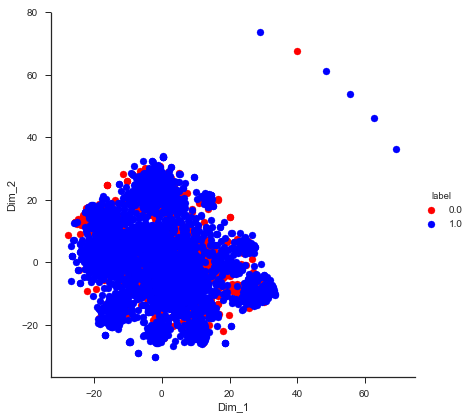

In [35]:
import seaborn as sn
import matplotlib.pyplot as plt

dataFrame = pd.DataFrame(data=bow_tsne_label_data, columns=("Dim_1", "Dim_2", "label"))
sn.set_style('ticks')
d = {'color': ['r', 'b']}
sn.FacetGrid(dataFrame,hue_kws = d,hue="label",size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# [5.2] Apply t-SNE on TF-IDF

(3000, 2)
(3000, 3)


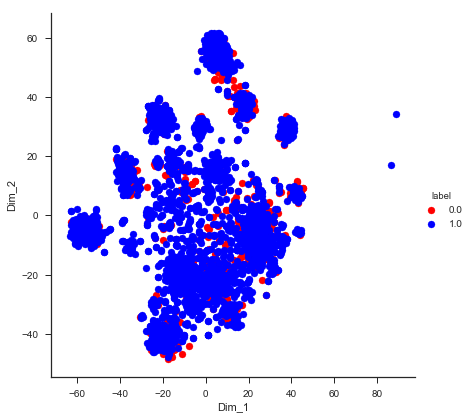

In [36]:
tf_idf_tsne_data = model.fit_transform(tf_idf_data)
print(tf_idf_tsne_data.shape)

tf_idf_tsne_label_data = np.vstack((tf_idf_tsne_data.T,scores_3000)).T
print(tf_idf_tsne_label_data.shape)

dataFrame = pd.DataFrame(data=tf_idf_tsne_label_data, columns=("Dim_1", "Dim_2", "label"))
sn.set_style('ticks')
sn.FacetGrid(dataFrame,hue_kws = d, hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# [5.3] Apply t-SNE on Avgearge W2V

(3000, 2)
(3000, 3)


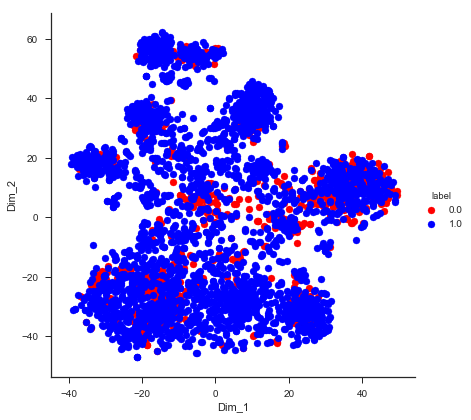

In [39]:
avg_w2v_tsne_data = model.fit_transform(avg_w2v)
print(avg_w2v_tsne_data.shape)

avg_w2v_tsne_label_data = np.vstack((avg_w2v_tsne_data.T,scores_3000)).T
print(avg_w2v_tsne_label_data.shape)

dataFrame = pd.DataFrame(data=avg_w2v_tsne_label_data, columns=("Dim_1", "Dim_2", "label"))
sn.set_style('ticks')
sn.FacetGrid(dataFrame, hue_kws = d,hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# [5.4] Apply t-SNE on TF-IDF weighted Word2Vec

(3000, 2)
(3000, 3)


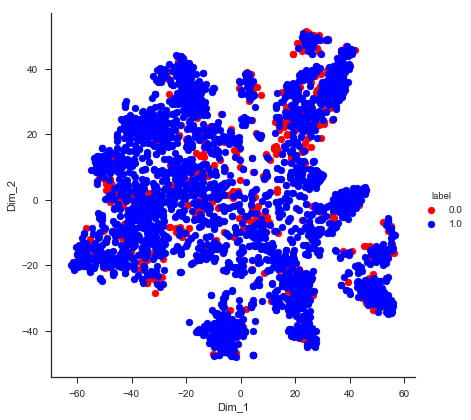

In [40]:
tfidf_wv_tsne_data = model.fit_transform(tfidf_wv)
print(tfidf_wv_tsne_data.shape)

tfidf_wv_tsne_label_data = np.vstack((tfidf_wv_tsne_data.T,scores_3000)).T
print(tfidf_wv_tsne_label_data.shape)

dataFrame = pd.DataFrame(data=tfidf_wv_tsne_label_data, columns=("Dim_1", "Dim_2", "label"))
sn.set_style('ticks')
sn.FacetGrid(dataFrame, hue_kws = d,hue="label", size=6).map(plt.scatter, 'Dim_1', 'Dim_2').add_legend()
plt.show()

# 6. Conclusion

    1. With 3000 data points, most of the points are overlapped in BoW t-SNE plot.
    2. With 3000 data points, most of the points are overlapped in TF-IDF t-SNE plot.
    3. With 3000 data points, most of the points are overlapped in average Word2Vec t-SNE plot.
    4. With 3000 data points, most of the points are overlapped in TF-IDF weighted Word2Vec t-SNE plot.

# 7. Reference

    1. Most of the above code snippets are referred from AAIC 'Amazon Fine Food Reviews Analysis.ipynb'